In [31]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
import random
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

In [32]:
# Set the random seed for reproducibility
seed = 24#23
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [33]:
def random_walk(samples, steps):
    positions = np.zeros(shape=(samples, 2))

    for step in range(steps):
        step = np.random.random(size=(samples, 2)) - 0.5
        norms = np.linalg.norm(step, axis=1)
        normalized_step = step/norms[:, np.newaxis]
        positions += normalized_step

    return positions
    
positions = random_walk(20000, 5).T

In [34]:
np.size(positions, axis=1)

20000

In [35]:
def calculate_probabilities(samples, batch_size, bins, steps):
    x_bins = np.linspace(-steps, steps, bins + 1)
    y_bins = np.linspace(-steps, steps, bins + 1)
    prob_map = []

    for i in range(int(np.size(samples, axis=1)/batch_size)):
        data = samples[:,i*batch_size:(i+1)*batch_size]
        map, _ , _ = np.histogram2d(data[0], data[1], bins=(x_bins, y_bins))
        prob_map.append(map)

    return np.array(prob_map)/batch_size
        
probs_map = calculate_probabilities(positions, 2000, 4, 5)

In [36]:
t = probs_map.reshape(10, 16)
t[0].sum()

1.0

In [37]:
class WalkDataset(Dataset):
    def __init__(self, probs):
        self.data = torch.tensor(probs, dtype=torch.float32) 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [38]:
# Create the data loader instance
dataset = WalkDataset(probs_map.reshape(10, 16))
dataloader = DataLoader(dataset, batch_size=1)

In [39]:
n_qubits = 4
n_a_qubits = 0
q_depth = 3 

In [40]:
# Discriminator implementation

class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(16, 40),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(40, 20),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(20, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        
        return self.model(x)


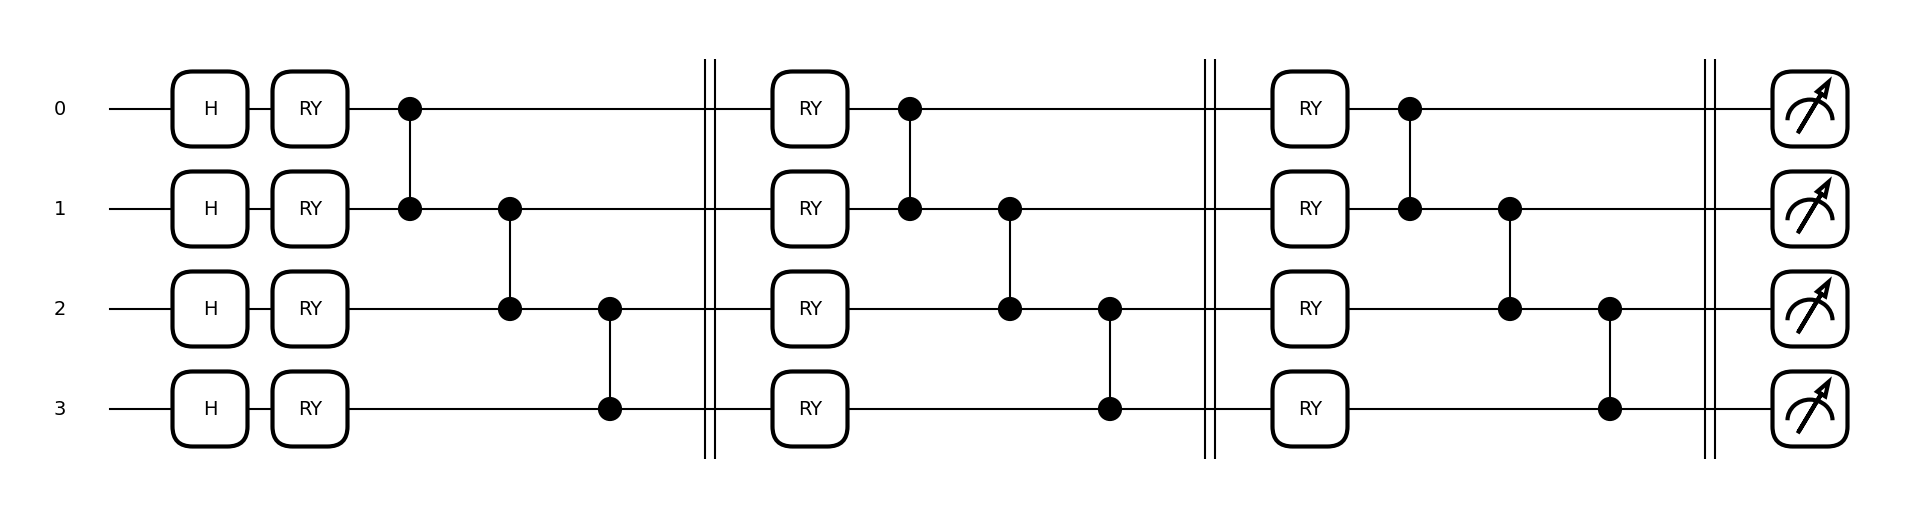

In [41]:
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

@qml.qnode(dev, diff_method="backprop")
def quantum_circuit(weights):

    weights = weights.reshape(q_depth, n_qubits)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

        #qml.CZ(wires=[5, 0])

        qml.Barrier(wires=list(range(n_qubits)), only_visual=True)

    return qml.probs(wires=list(range(n_qubits)))

noise = torch.rand(1, n_qubits, device=device) 
weights = torch.rand(1, n_qubits*q_depth) 

qml.draw_mpl(quantum_circuit)(weights=weights)
plt.show()

In [42]:
def partial_measure(weights):
    # Non-linear Transform
    probs = quantum_circuit(weights)
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
    probsgiven0 /= torch.sum(probs)

    return probsgiven0

In [43]:
class QuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(torch.rand(q_depth * n_qubits), requires_grad=True)
            ]
        )

    def forward(self):

        qc_out = quantum_circuit(self.q_params[0]).float().unsqueeze(0)
        
        return qc_out
        

In [44]:
discriminator = Discriminator().to(device)
generator = QuantumGenerator().to(device)

In [45]:
lrG = 0.3  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 500  # Number of training iterations

In [46]:
# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((1,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((1,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(1, n_qubits, device=device) * np.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
disc_loss = []
gen_loss = []

In [47]:
for i, data in enumerate(dataloader):
    #data = data.reshape(-1, data.size(0))
    real_data = data.to(device)

    #noise = torch.rand(1, n_qubits, device=device) * np.pi / 2
    fake_data = generator()

    discriminator.zero_grad()
    outD_real = discriminator(real_data).view(-1)
    outD_fake = discriminator(fake_data.detach()).view(-1)

In [48]:
while True:
    for i, data in enumerate(dataloader):

        # Data for training the discriminator
        #data = data.reshape(-1, data.size(0))
        real_data = data.to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        noise = torch.rand(1, n_qubits, device=device) * np.pi / 2
        fake_data = generator()

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        

        optD.step()
        

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        

        errG.backward()
        optG.step()

        

    # Show loss values
    if counter % 10 == 0:
        print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
        gen_loss.append(errG.detach())
        disc_loss.append(errD.detach())

    counter += 1
    if counter == num_iter:
        break

Iteration: 0, Discriminator Loss: 1.387, Generator Loss: 0.664
Iteration: 10, Discriminator Loss: 1.378, Generator Loss: 0.681
Iteration: 20, Discriminator Loss: 1.374, Generator Loss: 0.692
Iteration: 30, Discriminator Loss: 1.369, Generator Loss: 0.702
Iteration: 40, Discriminator Loss: 1.364, Generator Loss: 0.710
Iteration: 50, Discriminator Loss: 1.383, Generator Loss: 0.692
Iteration: 60, Discriminator Loss: 1.376, Generator Loss: 0.700
Iteration: 70, Discriminator Loss: 1.368, Generator Loss: 0.706
Iteration: 80, Discriminator Loss: 1.364, Generator Loss: 0.706
Iteration: 90, Discriminator Loss: 1.379, Generator Loss: 0.690
Iteration: 100, Discriminator Loss: 1.387, Generator Loss: 0.685
Iteration: 110, Discriminator Loss: 1.375, Generator Loss: 0.697
Iteration: 120, Discriminator Loss: 1.373, Generator Loss: 0.699
Iteration: 130, Discriminator Loss: 1.385, Generator Loss: 0.689
Iteration: 140, Discriminator Loss: 1.387, Generator Loss: 0.692
Iteration: 150, Discriminator Loss: 

# Test

In [49]:
t = generator().detach().numpy()
t = t.reshape(4, 4)
t

array([[0.00206806, 0.02782965, 0.02690741, 0.00407368],
       [0.02241523, 0.20655334, 0.21984114, 0.02438997],
       [0.02506431, 0.17752033, 0.19049133, 0.01599051],
       [0.0043601 , 0.02338681, 0.02752427, 0.00158376]], dtype=float32)

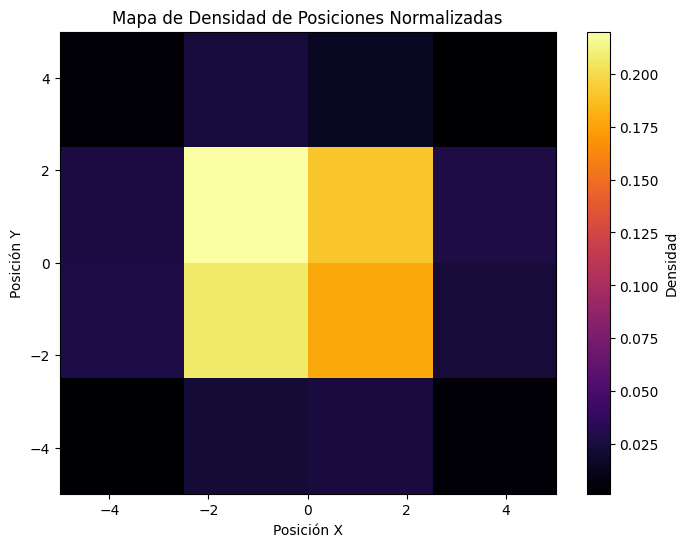

In [51]:

# Visualizar la densidad
plt.figure(figsize=(8, 6))
plt.imshow(t.T, extent=[-5, 5, -5, 5], origin='lower', cmap='inferno', aspect='auto')
plt.colorbar(label='Densidad')
plt.title('Mapa de Densidad de Posiciones Normalizadas')
plt.xlabel('Posición X')
plt.ylabel('Posición Y')
#plt.grid(True)
plt.show()
